In [1]:
#!pip install gym pyvirtualdisplay > /dev/null 2>&1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
#!apt-get update > /dev/null 2>&1
#!apt-get install cmake > /dev/null 2>&1
#!pip install --upgrade setuptools 2>&1
#!pip install ez_setup > /dev/null 2>&1
#!pip install gym[box2d]
#!pip install Box2D gym
#!pip install moviepy

In [3]:
import gym
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from moviepy.editor import ImageSequenceClip

import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

import random
import math

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    mp4list = glob.glob('/tmp/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

# Problem definition

[Car Racing](https://gymnasium.farama.org/environments/box2d/car_racing/) is a OpenAI's Gym environment. In this environment, the agent (a car) needs to learn how to navigate a racing track. The observation space typically includes pixel images from the car's perspective, and the action space consists of continuous actions like steering, acceleration, and braking.
The generated track is random every episode. Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: true speed, four ABS sensors, steering wheel position, and gyroscope.

## Action Space

If continuous there are 3 actions :

- 0: steering, -1 is full left, +1 is full right
- 1: gas
- 2: breaking

## If discrete there are 5 actions:

- 0: do nothing
- 1: steer left
- 2: steer right
- 3: gas
- 4: brake

## Observation Space

A top-down 96x96 RGB image of the car and race track.

## Rewards

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.
Starting State

The car starts at rest in the center of the road.

## Episode Termination
The episode finishes when all the tiles are visited. The car can also go outside the playfield - that is, far off the track, in which case it will receive -100 reward and die.

In [4]:
env = gym.make('CarRacing-v2')

observation, _ = env.reset()
env.render() 
rewardsum = 0  
previous_error = 0    

frames = []
frames.append(observation)

# Clear the first frames

In [5]:
for i in range(100):
    action = (0,0,0)
    observation, reward, done, _, info = env.step(action)

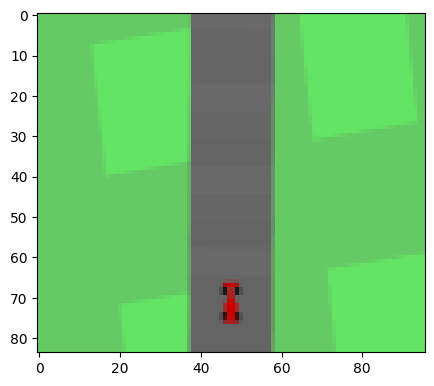

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize = (5,5))
ax1.imshow(observation[0:84, :])

# Image processing idea

The following code contains the image processor. What it does is described in the following paragraph.

In [7]:
class ImageProcessor:
    def green_mask(self, observation):
        hsv = cv2.cvtColor(observation, cv2.COLOR_BGR2HSV)
        mask_green = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

        ## slice the green
        imask_green = mask_green>0
        green = np.zeros_like(observation, np.uint8)
        green[imask_green] = observation[imask_green]
        return(green)

    def blur_image(self, observation):
        blur = cv2.GaussianBlur(observation, (5, 5), 0)
        return blur

    def canny_edge_detector(self, observation):
        canny = cv2.Canny(observation, 50, 150)
        return canny

    def find_error(self, observation, previous_error):
        cropped = observation[63:65, 24:73]

        green = self.green_mask(cropped)
        blur  = self.blur_image(green)
        canny = self.canny_edge_detector(blur)
        #canny = self.canny_edge_detector(green)
        
        # Find all non zero values in the cropped strip.
        # These non zero points(white pixels) corresponds to the edges of the road
        # The highest is the right boundary, while the lowest is the left boundary
        nz = cv2.findNonZero(canny)

        # Horizontal cordinates of center of the road in the cropped slice
        mid  = 24
        
        return(((nz[:,0,0].max() + nz[:,0,0].min())/2) - mid)
        #            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^    ^^^  
        #                             |-----------------------|--- position of the car
        #                                                     |--- wanted position

In [8]:
def show_images_with_filters(observation):
    with_rectangle = cv2.rectangle(np.copy(observation), (24, 63), (73, 65), (255,0,0), -1)

    cropped = observation[63:65, 24:73]

    green = IP.green_mask(cropped)
    blur  = IP.blur_image(green)
    canny = IP.canny_edge_detector(blur)
    canny_green = IP.canny_edge_detector(green)

    fig, ax = plt.subplots(2, 3, figsize = (15,10))

    ax[0][0].set_title("Region of interest")
    ax[0][0].imshow(with_rectangle)

    ax[0][1].set_title("Cropped region")
    ax[0][1].imshow(cropped)

    ax[0][2].set_title("Green mask")
    ax[0][2].imshow(green)

    ax[1][0].set_title("Blurred")
    ax[1][0].imshow(blur)

    ax[1][1].set_title("Canny edge detector")
    ax[1][1].imshow(canny)

    ax[1][2].set_title("Canny edge green")
    ax[1][2].imshow(canny_green)

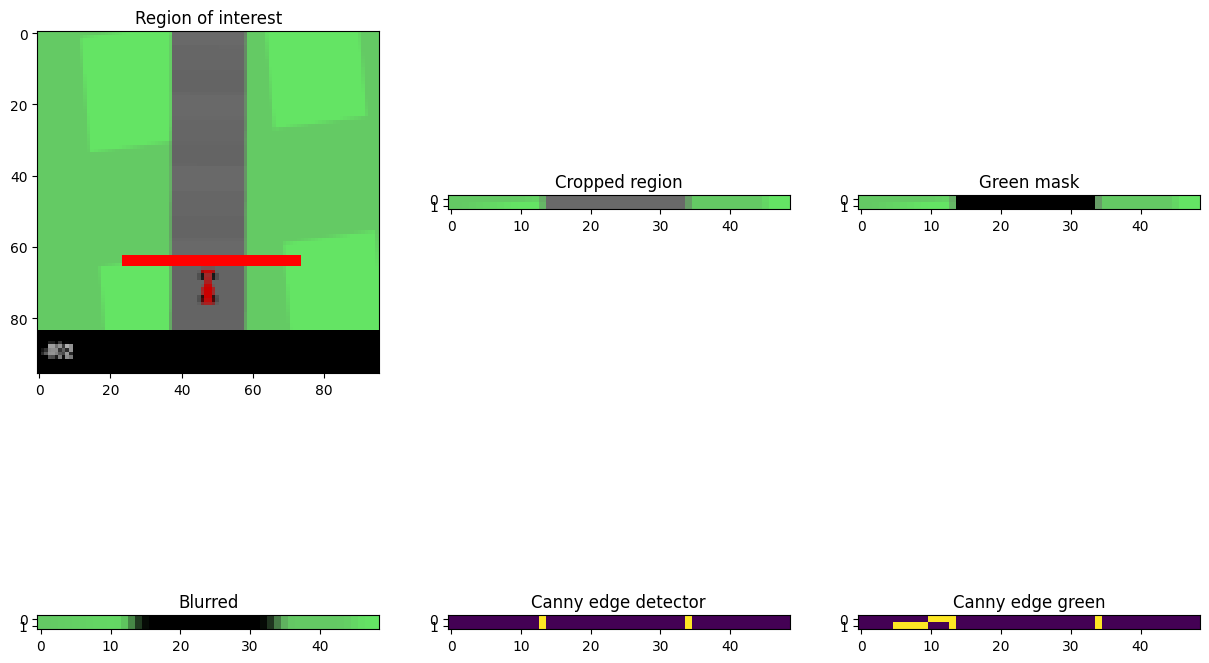

In [9]:
IP = ImageProcessor()

show_images_with_filters(observation)

## Image processing

The images contain the following:
1. The region of interest.
2. This cropped region.
3. The region with all colors except green removed (so the street is all zeros).
4. Blur is then applied to smoothen the image in case of colour differences.
5. The canny edge detector lets us extract only the borders of the street. We can use them to know the position of our car. We want the car to always be in the middle.
6. Canny edge applied to the green image. In case of non-smoothness of the image, some other points are going to be shown.

# Error calculation

To calculate the error we have to see how far away we are from the center of the street. The position can be determined by finding the average point between the two that the canny detector has identified.

In [10]:
cropped = observation[63:65, 24:73]
green = IP.green_mask(cropped)
blur  = IP.blur_image(green)
canny = IP.canny_edge_detector(blur)
nz = cv2.findNonZero(canny)
print(nz[:,0,0])
print((((nz[:,0,0].max() + nz[:,0,0].min())/2) - 24))

[13 34 13 34]
-0.5


This value is going to be the error.

In [11]:
IP.find_error(observation, 0)

-0.5

# Controller

I chose to implement a PID controller.

In [12]:
def pid(error,previous_error):
    Kp = 0.02
    Ki = 0.03
    Kd = 0.2   

    steering = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return steering

In [13]:
errors_count = 0

exceptions = []

for x in [1,0]*500:        
    try:
        error = IP.find_error(observation, previous_error)
    except:
        error = -15
        errors_count += 1
        exceptions.append(observation)

    steering = pid(error,previous_error)

    action = (steering,x,0)

    observation, reward, done, _, info = env.step(action)

    frames.append(observation)
    previous_error =error
    rewardsum = rewardsum +reward
    
    if done :
        env.close()
        break

print("Exceptions:", errors_count)

Exceptions: 91


# Performance of the controller

In [14]:
def export_and_show_video(frames):
    clip = ImageSequenceClip(frames, fps=30)
    os.system("export FFMPEG_BINARY=/usr/bin/ffmpeg")
    clip.write_videofile("/tmp/test.mp4",)
    show_video()

In [15]:
class ImageProcessor3(ImageProcessor):
    def find_error_and_position(self, observation, previous_error):
        cropped = observation[63:65, 24:73]

        green = self.green_mask(cropped)
        blur  = self.blur_image(green)
        canny = self.canny_edge_detector(blur)
        
        # Find all non zero values in the cropped strip.
        # These non zero points(white pixels) corresponds to the edges of the road
        # The highest is the right boundary, while the lowest is the left boundary
        nz = cv2.findNonZero(canny)
        
        if nz is None:
            if random.randint(0,1) == 0:
                error = previous_error
            else:
                error = random.randint(-15, 15)
            return 0, error
        # Horizontal cordinates of center of the road in the cropped slice
        mid  = 24
        predicted_position = (nz[:,0,0].max() + nz[:,0,0].min())/2
        return predicted_position, (predicted_position - mid)

In [16]:
env.reset()
for _ in range(100):
    env.step((0,0,0)) # clean the map

IP = ImageProcessor3()
positions = []
steerings = []
frames = []
exceptions = []

for x in [1,0]*500:
    predicted_position, error = IP.find_error_and_position(observation, previous_error)

    steering = pid(error,previous_error)

    action = (steering,x,0)

    observation, reward, done, _, info = env.step(action)

    previous_error = error
    rewardsum = rewardsum +reward
    
    positions.append(predicted_position)
    steerings.append(steering)
    frames.append(observation)
    
    if predicted_position <= 0:
        exceptions.append(observation)

    if done :
        env.close()
        break


In [17]:
time = np.linspace(0, len(positions)/30, num=len(positions))

org = (60, 90)
font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 0.5
color = (255, 0, 0) 
thickness = 2

for i in range(len(frames)):
    frames[i] = cv2.putText(frames[i], str(int(time[i]*10)/10), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
export_and_show_video(frames)

Moviepy - Building video /tmp/test.mp4.
Moviepy - Writing video /tmp/test.mp4



Moviepy - Done !
Moviepy - video ready /tmp/test.mp4


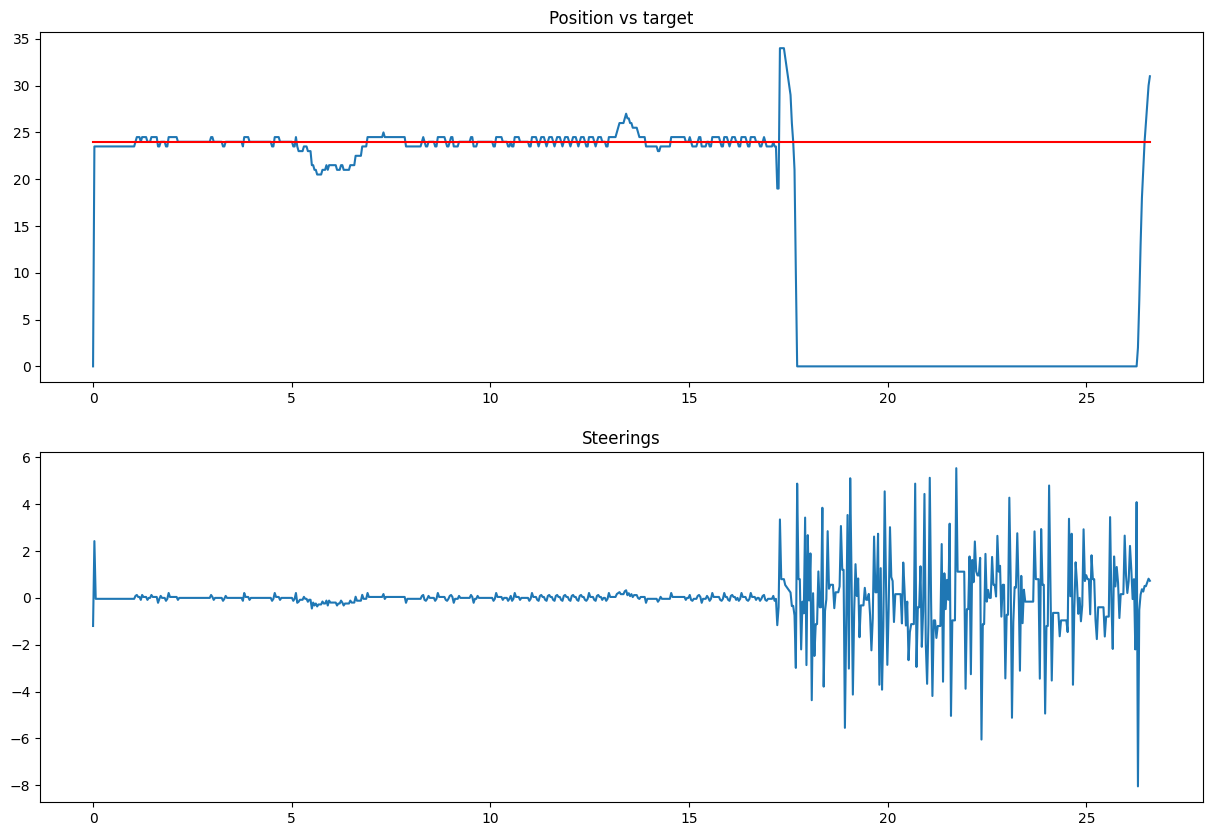

In [18]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))

ax[0].set_title("Position vs target")
ax[0].plot(time, positions)
ax[0].plot(time, [24 for _ in positions], "r")

ax[1].set_title("Steerings")
ax[1].plot(time, steerings)

# Exception analysis

In [19]:
export_and_show_video(frames)

Moviepy - Building video /tmp/test.mp4.
Moviepy - Writing video /tmp/test.mp4



Moviepy - Done !
Moviepy - video ready /tmp/test.mp4


In [20]:
def show_some_exceptions(exceptions, how_many):
    indexes = np.linspace(0, how_many)
    cols = 5
    rows = int(how_many / cols)
    fig, ax = plt.subplots(rows, cols, figsize = (15,10))

    for i in range(how_many):
        j = int(indexes[i])
        ax[int(i / cols)][i % cols].imshow(exceptions[j])

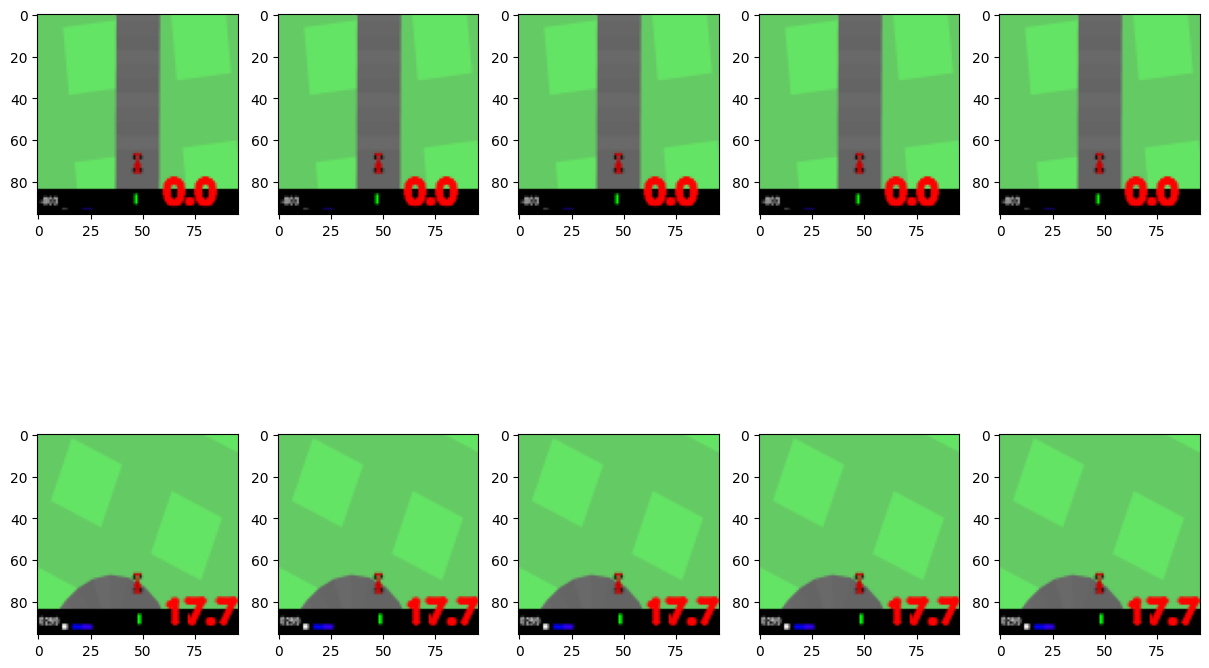

In [21]:
if len(exceptions) == 0:
    print("Lucky")
else:
    show_some_exceptions(exceptions, min(10, len(exceptions)))

We can notice that when the car reaches the grass, the controller is not able to put it back into the track.

In [39]:
if len(exceptions) != 0:
    show_images_with_filters(exceptions[-5])

The error function is not able to return an error because, since we are removing all the green, we are not able to calculate the error. A non-perfect way to address this problem is to either return a random error or the previous error randomly.

In [23]:
frames = []

In [24]:
class ImageProcessor2(ImageProcessor):
    def find_error(self, observation, previous_error):
        cropped = observation[63:65, 24:73]

        green = self.green_mask(cropped)
        blur  = self.blur_image(green)
        canny = self.canny_edge_detector(blur)
        
        # Find all non zero values in the cropped strip.
        # These non zero points(white pixels) corresponds to the edges of the road
        # The highest is the right boundary, while the lowest is the left boundary
        nz = cv2.findNonZero(canny)
        
        if nz is None:
            if random.randint(0,1) == 0:
                return previous_error
            else:
                return random.randint(-15, 15)

        # Horizontal cordinates of center of the road in the cropped slice
        mid  = 24
        
        return(((nz[:,0,0].max() + nz[:,0,0].min())/2) - mid)

In [25]:
errors_count = 0

IP = ImageProcessor2()
exceptions = []

for x in [1,0]*500:        
    try:
        error = IP.find_error(observation, previous_error)
    except:
        error = random.randint(-15, 15)
        errors_count += 1
        exceptions.append(observation)

    steering = pid(error,previous_error)

    action = (steering,x,0)

    observation, reward, done, _, info = env.step(action)

    frames.append(observation)
    previous_error = error
    rewardsum = rewardsum +reward
    
    if done :
        env.close()
        break

print("Exceptions:", errors_count)

Exceptions: 0


In [26]:
export_and_show_video(frames)

Moviepy - Building video /tmp/test.mp4.
Moviepy - Writing video /tmp/test.mp4



Moviepy - Done !
Moviepy - video ready /tmp/test.mp4


# Tuning to let the controller complete all kind of turns

In [27]:
frames_broken_ = np.load("frames_with_problem.npy").tolist()
frames_broken = [np.array(a).astype("uint8") for a in frames_broken_]

In [28]:
export_and_show_video(frames_broken[600:650])

Moviepy - Building video /tmp/test.mp4.
Moviepy - Writing video /tmp/test.mp4



Moviepy - Done !
Moviepy - video ready /tmp/test.mp4


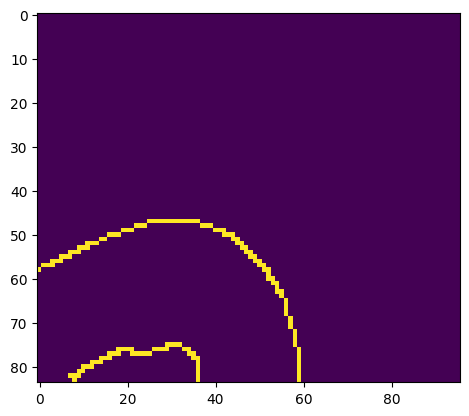

In [29]:
cropped = frames_broken[620][0:84, 0:96]
green = IP.green_mask(cropped)
blur  = IP.blur_image(green)
canny = IP.canny_edge_detector(blur)

plt.imshow(canny)

In this case we have a steep curve, so we should slow down

In [30]:
class ImageProcessor2(ImageProcessor):
    def braking_force(self, canny):
        idx = [0 for i in range(4)]
        idx[0] = cv2.findNonZero(canny[0, 0:95])
        idx[1] = cv2.findNonZero(canny[0:83, 95])
        idx[2] = cv2.findNonZero(canny[83, 0:95])
        idx[3] = cv2.findNonZero(canny[0:83, 0])

        for i in range(len(idx)):
            if idx[i] is not None:
                idx[i] = idx[i].max()
        
        return idx
        
    def find_error_braking_position(self, observation, previous_error):
        green = self.green_mask(observation)
        blur  = self.blur_image(green)
        canny = self.canny_edge_detector(blur)
        
        idx = self.braking_force(canny)
        canny = canny[63:65, 24:73]
        
        nz = cv2.findNonZero(canny)
        mid  = 24
        
        if nz is not None:
            predicted_position = ((nz[:,0,0].max() + nz[:,0,0].min())/2)
            if (nz[:,0,0].max() - nz[:,0,0].min()) > 5:
                # needed in case only one edge of the street is visible
                steer = (predicted_position - mid)
            else:
                #if nz[:,0,0].max() <30 and nz[:,0,0].max()>20:
                #    steer = previous_error
                if nz[:,0,0].max() >= mid:
                    steer = -15
                else:
                    steer = +15
        else:
            predicted_position = -1
            steer = previous_error

            # # steer < 0 => going left
            if idx[1] is not None:
                # check it's going to the right
                if steer < 0:
                    steer = 5
            if idx[3] is not None:
                # check it's going to the left
                if steer > 0:
                    steer = -5
        
        braking_force = 0
        if idx[1] is not None:
            braking_force = idx[1]/83
            
        if idx[3] is not None:
            braking_force = idx[3]/83
        
        return steer, braking_force, predicted_position

In [31]:
# idx = -30
# green = IP2.green_mask(frames[idx])
# blur  = IP2.blur_image(green)
# canny = IP2.canny_edge_detector(blur)
# canny = canny[63:65, 24:73]
# plt.imshow(canny)
# IP2.find_error(frames[idx], 0)

<img src="img/p.png" />
<img src="img/d.png" />
<img src="img/i.png" />

In [32]:
env.reset()
for _ in range(100):
    env.step((0,0,0))

braking_forces = []
steerings = []
frames = []
target_speeds = []
true_speeds = []
positions = []
steerings = []
steerings_errors = []
accelerations = []

IP2 = ImageProcessor2()

SPEEDS = [1, 0, 1]
BRAKING_FORCE_FACTOR = 0.9
CORNERING_SPEED = 40
STRAIGHT_SPEED = 100

org = (60, 90)
org_steering = (10, 90)
font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 0.5
color = (255, 0, 0) 
thickness = 2

slow_down_count = 0
previous_error = 0
previous_speed_error = 0

In [33]:
def pid_speed(error,previous_error):
    Kp = 0.0001
    Ki = 0.03
    Kd = 0.3

    speed = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return speed

def pid(error,previous_error,Kp=0.02):
    #Kp = 0.02
    Ki = 0.03
    Kd = 0.5    

    steering = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return steering

In [34]:
for _ in range(3000):
    error, braking_force, position = IP2.find_error_braking_position(observation, previous_error)
    true_speed = np.sqrt(
        np.square(env.car.hull.linearVelocity[0])
        + np.square(env.car.hull.linearVelocity[1])
    )
    
    steering = pid(error,previous_error)
    
    # START PID CONTROLLER FOR SPEED
    
    if braking_force > 0:
        # cornering
        speed_target = CORNERING_SPEED
    else:
        speed_target = STRAIGHT_SPEED
        
    if true_speed > CORNERING_SPEED + 10 and (abs(steering) > 1 or abs(error) > 1):
        speed_target = CORNERING_SPEED
        observation = cv2.putText(observation, "s", org_steering, font,  
                 fontScale, color, thickness, cv2.LINE_AA)
        braking_force_reference = 0.1 + abs(true_speed - CORNERING_SPEED)/max(true_speed, CORNERING_SPEED)
        braking_force = max(braking_force, braking_force_reference)
        Kp = 0.05
    else:
        Kp = 0.03
    steering = pid(error,previous_error,Kp=Kp)
    speed_error = speed_target - true_speed
    acceleration = pid(speed_error, previous_speed_error)
    previous_speed_error = speed_error
    
    if acceleration < 0 or true_speed > CORNERING_SPEED + 5:
        bf = braking_force * BRAKING_FORCE_FACTOR
    else:
        bf = 0
    # END PID CONTROLLER FOR SPEED
    
    target_speeds.append(speed_target)
    true_speeds.append(true_speed)
    positions.append(position)
    steerings.append(steering)
    steerings_errors.append(error)
    accelerations.append(acceleration)
    braking_forces.append(bf)
        
    action = (steering, acceleration, bf)

    observation, reward, done, _, info = env.step(action)

    previous_error = error
    rewardsum = rewardsum +reward
    
    # observation = cv2.putText(observation, str(int(bf*10)/10), org, font,  
    #            fontScale, color, thickness, cv2.LINE_AA)
    # observation = cv2.putText(observation, str(int(steering*10)/10), org_steering, font,  
    #                fontScale, color, thickness, cv2.LINE_AA)
    frames.append(observation)

    if done :
        env.close()
        break


In [35]:
time = np.linspace(0, len(positions)/30, num=len(positions))

org = (60, 90)
font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 0.5
color = (255, 0, 0) 
thickness = 2

for i in range(len(frames)):
    frames[i] = cv2.putText(frames[i], str(int(time[i]*10)/10), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 

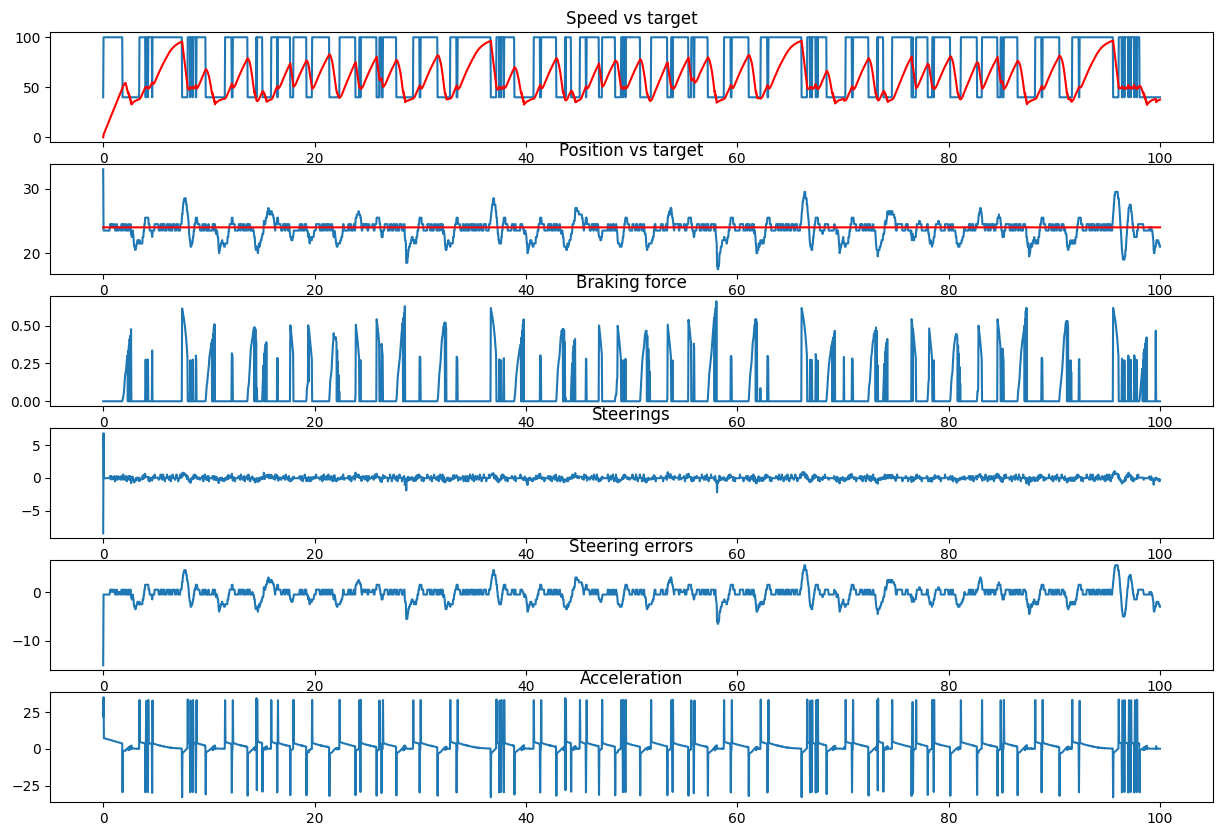

In [36]:
fig, ax = plt.subplots(6  , 1, figsize = (15,10))

i=0

ax[i].set_title("Speed vs target")
ax[i].plot(time, target_speeds)
ax[i].plot(time, true_speeds, "r")
i+=1

ax[i].set_title("Position vs target")
ax[i].plot(time, positions)
ax[i].plot(time, [24 for _ in positions], "r")
i+=1

ax[i].set_title("Braking force")
ax[i].plot(time, braking_forces)
i+=1

ax[i].set_title("Steerings")
ax[i].plot(time, steerings)
i+=1

ax[i].set_title("Steering errors")
ax[i].plot(time, steerings_errors)
i+=1

ax[i].set_title("Acceleration")
ax[i].plot(time, accelerations)

In [37]:
export_and_show_video(frames)

Moviepy - Building video /tmp/test.mp4.
Moviepy - Writing video /tmp/test.mp4



Moviepy - Done !
Moviepy - video ready /tmp/test.mp4
